In [1]:
import os
import random
from typing import *
from xml.dom import INDEX_SIZE_ERR
import numpy as np
import joblib
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
from tqdm import tqdm
from matplotlib import pyplot as plt
import scallopy
from skimage.transform import resize
import cv2

In [ ]:
mnist_img_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), (0.3081,)
    )
    ]
)

class MNISTSum2Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
  
    ):
    # Contains a MNIST dataset
        self.mnist_dataset = torchvision.datasets.MNIST(
        root,
        train=train,
        transform=transform,
        target_transform=target_transform,
        download=download,
        )
        self.index_map = list(range(len(self.mnist_dataset)))
        random.shuffle(self.index_map)
    
    def __len__(self):
        return int(len(self.mnist_dataset) / 2)
    
    def __getitem__(self, idx):
        # Get two data points
        (a_img, a_digit) = self.mnist_dataset[self.index_map[idx * 2]]
        (b_img, b_digit) = self.mnist_dataset[self.index_map[idx * 2 + 1]]
        # Each data has two images and the GT is the sum of two digits
        return (a_img, b_img, a_digit + b_digit)
    
    @staticmethod
    def collate_fn(batch):
        a_imgs = torch.stack([item[0] for item in batch])
        b_imgs = torch.stack([item[1] for item in batch])
        digits = torch.stack([torch.tensor(item[2]).long() for item in batch])
        return ((a_imgs, b_imgs), digits)

In [ ]:
def mnist_sum_2_loader(data_dir, batch_size_train, batch_size_test):
    train_loader = torch.utils.data.DataLoader(
        MNISTSum2Dataset(
        data_dir,
        train=True,
        download=True,
        transform=mnist_img_transform,
        ),
        collate_fn=MNISTSum2Dataset.collate_fn,
        batch_size=batch_size_train,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        MNISTSum2Dataset(
        data_dir,
        train=False,
        download=True,
        transform=mnist_img_transform,
        ),
        collate_fn=MNISTSum2Dataset.collate_fn,
        batch_size=batch_size_test,
        shuffle=True
    )
    return train_loader, test_loader


In [ ]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.max_pool2d(self.conv2(x), 2)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p = 0.5, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [ ]:
class MNISTSum2Net(nn.Module):
    def __init__(self, provenance, k):
        super(MNISTSum2Net, self).__init__()

        # MNIST Digit Recognition Network
        self.mnist_net = MNISTNet()

        # Scallop Context
        self.scl_ctx = scallopy.ScallopContext(provenance=provenance, k=k)
        self.scl_ctx.add_relation("digit_1", int, input_mapping=list(range(10)))
        self.scl_ctx.add_relation("digit_2", int, input_mapping=list(range(10)))
        self.scl_ctx.add_rule("sum_2(a + b) :- digit_1(a), digit_2(b)")

        # The `sum_2` logical reasoning module
        self.sum_2 = self.scl_ctx.forward_function("sum_2", output_mapping=[(i,) for i in range(19)])

    def forward(self, x: Tuple[torch.Tensor, torch.Tensor]):
        (a_imgs, b_imgs) = x

        # First recognize the two digits
        a_distrs = self.mnist_net(a_imgs) # Tensor 64 x 10
        b_distrs = self.mnist_net(b_imgs) # Tensor 64 x 10

        # Then execute the reasoning module; the result is a size 19 tensor
        return self.sum_2(digit_1=a_distrs, digit_2=b_distrs) # Tensor 64 x 19

def bce_loss(output, ground_truth):
    (_, dim) = output.shape
    gt = torch.stack([torch.tensor([1.0 if i == t else 0.0 for i in range(dim)]) for t in ground_truth])
    return F.binary_cross_entropy(output, gt)


def nll_loss(output, ground_truth):
    return F.nll_loss(output, ground_truth)

class Trainer():
    def __init__(self, train_loader, test_loader, learning_rate, loss, k, provenance):
        self.network = MNISTSum2Net(provenance, k)
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
        self.train_loader = train_loader
        self.test_loader = test_loader
        if loss == "nll":
            self.loss = nll_loss
        elif loss == "bce":
            self.loss = bce_loss
        else:
            raise Exception(f"Unknown loss function `{loss}`")

    def train_epoch(self, epoch):
        self.network.train()
        iter = tqdm(self.train_loader, total=len(self.train_loader))
        for (data, target) in iter:
            self.optimizer.zero_grad()
            output = self.network(data)
            loss = self.loss(output, target)
            loss.backward()
            self.optimizer.step()
            iter.set_description(f"[Train Epoch {epoch}] Loss: {loss.item():.4f}")

    def test(self, epoch):
        self.network.eval()
        num_items = len(self.test_loader.dataset)
        test_loss = 0
        correct = 0
        with torch.no_grad():
            iter = tqdm(self.test_loader, total=len(self.test_loader))
            for (data, target) in iter:
                output = self.network(data)
                test_loss += self.loss(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
                perc = 100. * correct / num_items
                iter.set_description(f"[Test Epoch {epoch}] Total loss: {test_loss:.4f}, Accuracy: {correct}/{num_items} ({perc:.2f}%)")

    def train(self, n_epochs):
        self.test(0)
        for epoch in range(1, n_epochs + 1):
            self.train_epoch(epoch)
            self.test(epoch)

In [8]:
class MNISTgenerator(torch.utils.data.Dataset):
    def __init__(
        self,
        root: str,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        no_of_digits: int = 2
    ):    
        # Contains a MNIST dataset
        self.mnist_dataset = torchvision.datasets.MNIST(
        root,
        train=train,
        transform=transform,
        target_transform=target_transform,
        download=download,
        )
        self.index_map = list(range(len(self.mnist_dataset)))
        random.shuffle(self.index_map)
        self.no_of_digits = no_of_digits

    def __len__(self):
        return int(len(self.mnist_dataset) / 2)

    def __getitem__(self, idx):
        print("no_of_digits ", self.no_of_digits)       
        image_tensors = []
        digits_sum = 0
        img_size = 28*self.no_of_digits
        for i in range(2):
            images,labels = [],[]            
            for j in range(self.no_of_digits):
                (img, digit) = self.mnist_dataset[self.index_map[random.randint(0,len(self.index_map))]]
                images.append(img)
                labels.append(digit)
            im_1 = images[0]
            num = labels[0]
            for idx in range(1,len(images)):
                im_1 = torch.hstack((im_1.squeeze(),images[idx].squeeze()))
                num = str(num)+str(labels[idx])
            if self.no_of_digits>1:
                im_1 = torch.tensor(resize(im_1,(img_size,img_size))).unsqueeze(dim=0)
            image_tensors.append(im_1)
            digits_sum = digits_sum + int(num)

        # Each data has two images and the GT is the sum of two digits
        # return (im_1, im_2, ab+cd)
        return (image_tensors[0],image_tensors[1], digits_sum)

    @staticmethod
    def collate_fn(batch):
        a_imgs = torch.stack([item[0] for item in batch])
        b_imgs = torch.stack([item[1] for item in batch])
        digits = torch.stack([torch.tensor(item[2]).long() for item in batch])
        return ((a_imgs, b_imgs), digits)

def mnist_gen_loader(data_dir, batch_size_train, batch_size_test, no_of_digits = 2):
    train_loader = torch.utils.data.DataLoader(
        MNISTgenerator(
        data_dir,
        train=True,
        download=True,
        transform=mnist_img_transform,
        no_of_digits = no_of_digits
        ),
        collate_fn=MNISTSum2Dataset.collate_fn,
        batch_size=batch_size_train,
        shuffle=True
    )

    test_loader = torch.utils.data.DataLoader(
        MNISTgenerator(
        data_dir,
        train=False,
        download=True,
        transform=mnist_img_transform,
        no_of_digits = no_of_digits
        ),
        collate_fn=MNISTSum2Dataset.collate_fn,
        batch_size=batch_size_test,
        shuffle=True
    )

    return train_loader, test_loader

def identify_image_segments(
    image
):
    index = []
    img_tensors = []
    image_elements = image.squeeze()>0
    for i in range(image.shape[-1]):
        if not torch.sum(image_elements[:,i]):
            index.append(i)
    idx = np.where(np.array(index)[1:] - np.array(index[:-1])>1)
    for i in idx[0]:
        img_tensors.append(torch.tensor(resize(image.squeeze()[:,index[i]:index[i+1]],(28,28))).unsqueeze(dim=0))
    if idx == 0:
        img_tensors.append(torch.tensor(resize(image.squeeze(),(28,28))).unsqueeze(dim=0)).unsqueeze(dim=0)
    return img_tensors


In [ ]:
def load_model():
    """
    Load trained model for inference
    """
    mnist_model = joblib.load('model/mnist_model')
    return mnist_model
    
def show_image(img_1, img_2, sum_of_numbers):
    fig = plt.figure()
    plt.title('Predicted Sum ==> '+ str(sum_of_numbers))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img_1.squeeze())
    ax1.set_title('Input 1')
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img_2.squeeze())
    ax2.set_title('Input 2')
    plt.show()

In [ ]:
class Model_Inference:
    """
    Class for inference. Generator method would 
    """
    def __init__(self,no_of_digits = 2) -> None:
        self.mnist_model = load_model()
        self.no_of_digits = no_of_digits
        self.gen_train_loader, self.gen_test_loader = mnist_gen_loader('./data', 1, 1, self.no_of_digits)

    def get_model(self):
        return self.mnist_model

    def sum_numbers_genereator_images(self):
        """
        Predict sum of input images.
        Assumption - both input images have same number of digits
        """
        gen_images, gen_labels = iter(self.gen_test_loader).next()
        img_1, img_2 = gen_images[0][0], gen_images[1][0]
        img_1_tensors, img_2_tensors = identify_image_segments(img_1), identify_image_segments(img_2)
        sum_of_numbers = ''
        prev_rem = 0
        for idx in range(len(img_1_tensors)-1,-1,-1):
            digit_sum = torch.argmax(self.mnist_model((img_1_tensors[idx],img_2_tensors[idx])))
            rem, unit = digit_sum.numpy().item()//10, digit_sum.numpy().item()%10
            sum_of_numbers = str(unit+prev_rem)+str(sum_of_numbers)
            prev_rem = rem
        sum_of_numbers = int(str(rem)+str(sum_of_numbers))
        print("****** Results******")
        print("Sum from model -->", sum_of_numbers)
        print("Actual Sum -->", gen_labels.numpy().item())

        return img_1, img_2, sum_of_numbers
    


In [ ]:
# if __name__ == "__main__":
#     # Argument parser
#     parser = ArgumentParser("mnist_sum_2")
#     parser.add_argument("--n-epochs", type=int, default=10)
#     parser.add_argument("--batch-size-train", type=int, default=64)
#     parser.add_argument("--batch-size-test", type=int, default=64)
#     parser.add_argument("--learning-rate", type=float, default=0.001)
#     parser.add_argument("--loss-fn", type=str, default="bce")
#     parser.add_argument("--seed", type=int, default=1234)
#     parser.add_argument("--provenance", type=str, default="difftopkproofs")
#     parser.add_argument("--top-k", type=int, default=3)
#     args = parser.parse_args()

#     # Parameters
#     n_epochs = args.n_epochs
#     batch_size_train = args.batch_size_train
#     batch_size_test = args.batch_size_test
#     learning_rate = args.learning_rate
#     loss_fn = args.loss_fn
#     k = args.top_k
#     provenance = args.provenance
#     torch.manual_seed(args.seed)
#     random.seed(args.seed)

#     # Data
#     # data_dir = os.path.abspath(os.path.join(os.path.abspath(__file__), "../../data"))
#     data_dir = '../data'

#     # Dataloaders
#     train_loader, test_loader = mnist_sum_2_loader(data_dir, batch_size_train, batch_size_test)

#     # Create trainer and train
#     trainer = Trainer(train_loader, test_loader, learning_rate, loss_fn, k, provenance)
#     trainer.train(n_epochs)

#     """uncomment if model needs to be saved, this will overwrite the current 
#     model being used for inference"""
#     # joblib.dump(trainer.network, 'model/mnist_model')

## Output Demos 

no_of_digits  2
****** Results******
Sum from model --> 76
Actual Sum --> 76


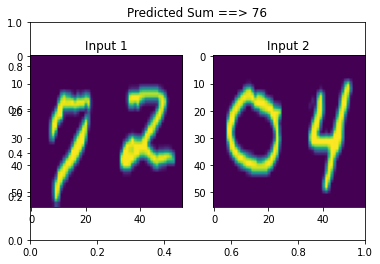

In [79]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)


no_of_digits  2
****** Results******
Sum from model --> 83
Actual Sum --> 83


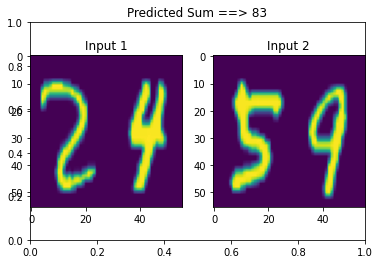

In [81]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  2
****** Results******
Sum from model --> 159
Actual Sum --> 159


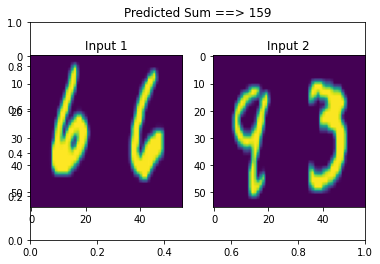

In [82]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  2
****** Results******
Sum from model --> 162
Actual Sum --> 162


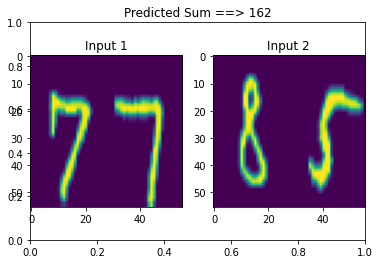

In [83]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  3
****** Results******
Sum from model --> 724
Actual Sum --> 724


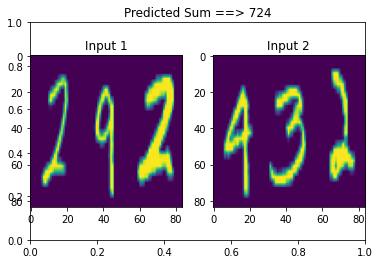

In [84]:
model_inference = Model_Inference(no_of_digits = 3)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  3
****** Results******
Sum from model --> 1173
Actual Sum --> 1173


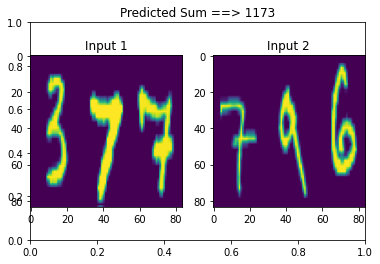

In [88]:
model_inference = Model_Inference(no_of_digits = 3)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  3
****** Results******
Sum from model --> 1030
Actual Sum --> 1030


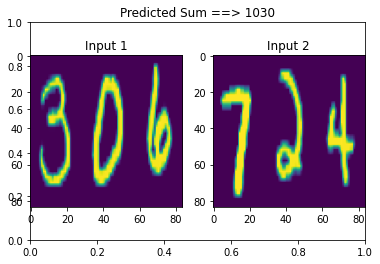

In [89]:
model_inference = Model_Inference(no_of_digits = 3)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  2
****** Results******
Sum from model --> 146
Actual Sum --> 146


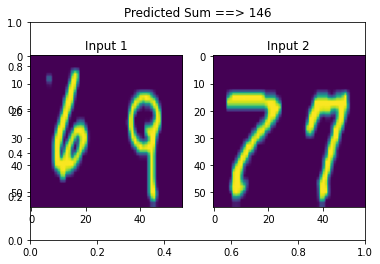

True

In [8]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)

no_of_digits  2
****** Results******
Sum from model --> 61
Actual Sum --> 61


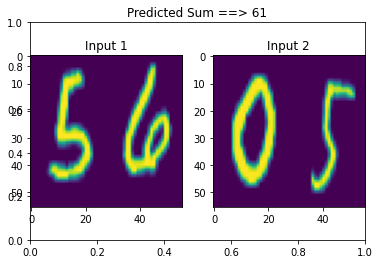

In [4]:
model_inference = Model_Inference(no_of_digits = 2)
img_1, img_2, sum_of_numbers = model_inference.sum_numbers_genereator_images()
show_image(img_1, img_2, sum_of_numbers)
cv2.imwrite("test-images/img_1.png", img_1.numpy().reshape(56,56,1))
cv2.imwrite("test-images/img_2.png", img_2.numpy().reshape(56,56,1))